In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from skimage.draw import line
import nibabel as nib
import torch
import torchkbnufft as tkbn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [2]:
# functions for downsample

def cartesian_mask(factor, orientation, distribution):
    acceleration, center_fraction = factor
    size = 320
    mask = np.zeros((size, size), dtype=bool)
    num_cols = size
    num_low_frequencies = round(num_cols * center_fraction)
       
    if (distribution == "uniform"):
        adjusted_accel = round((acceleration * (num_low_frequencies - num_cols)) / (num_low_frequencies * acceleration - num_cols))
        offset = np.random.randint(0, round(adjusted_accel))
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
    elif (distribution == "random"):
        prob = (num_cols / acceleration - num_low_frequencies) / (num_cols - num_low_frequencies)
        accel_samples = np.random.uniform(size=num_cols) < prob
    
    if (orientation == "horizontal"):
        mask[:, round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2)] = True
        mask[:, accel_samples] = True
    elif (orientation == "vertical"):
        mask[int((num_cols - num_low_frequencies - 2) / 2):int((num_cols + num_low_frequencies - 2) / 2), :] = True
        mask[accel_samples,:] = True
 
    return mask

def radial_mask(factor):
    size = 320
    r = round(size/2)
    mask = np.zeros((size, size), dtype=bool)
    for i in range(0, size + 1, factor):
        img = np.zeros((size, size), dtype=np.float32)
        angle = i/size * (2*np.pi)
        r1 = round(r*np.cos(angle))
        c1 = round(r*np.sin(angle))
        rr, cc = line(r, r, r+r1, r+c1) #(r0, c0, r1, c1)
    
        cc = cc[rr < size]
        rr = rr[rr < size]
        rr = rr[cc < size]
        cc = cc[cc < size]
        img[rr, cc] = 1
        mask = mask | (img > 0)
    
    return mask

In [3]:
# functions for motion
def normalise_image(image):
    """Normalise image 0 to 1."""
    image = torch.abs(image)
    if (image.max() - image.min()) < 1e-5:
        return image - image.min() + 1e-5
    else:
        return (image - image.min()) / (image.max() - image.min())

def rotation_matrix_2d(ang, device=None):
    """2D rotation matrix."""
    ang = torch.deg2rad(ang)
    return torch.tensor([[torch.cos(ang), -torch.sin(ang)],
                         [torch.sin(ang), torch.cos(ang)]], device=device)

def translate_opt(F, ktraj, t, device=None):
    """Translate k-space optimizable."""
    shape = F.shape
    phase = torch.matmul(t, ktraj)
    shift_real = torch.cos(phase)
    shift_imag = torch.sin(phase)
    shift = torch.complex(shift_real, shift_imag).to(device)
    F = shift * F.flatten()
    return torch.reshape(F, shape)

def sample_movements(n_movements, ndims, angles_std=5.0, trans_std=10.0, device=None):
    """Sample movement affine transforms."""
    affines = []
    angles = angles_std * torch.randn((n_movements+1,), dtype=torch.float32, device=device)
    trans = trans_std * torch.randn((n_movements+1,2), dtype=torch.float32, device=device)
    for i in range(n_movements+1):
        ang = angles[i]
        t = trans[i,:]
        A = torch.eye(ndims+1).to(device)
        R = rotation_matrix_2d(ang, device=device)
        A[:ndims,:ndims] = R.to(device)
        A[:ndims,ndims] = t.to(device)
        affines.append(A)
    return affines, angles, trans

def gen_masks(n_movements, locs, grid_size):
    """Generate k-space masks."""
    masks = []
    mask = torch.arange(0,locs[0],dtype=torch.long,device=device)
    masks.append(mask)
    for i in range(1,n_movements):
        mask = torch.arange(locs[i-1],locs[i],dtype=torch.long,device=device)
        masks.append(mask)
    mask = torch.arange(locs[-1],grid_size[0],dtype=torch.long,device=device)
    masks.append(mask)        
    return masks

def gen_ktraj(nlines, klen, device=None):
    """Generate kx, ky"""
    kx = torch.linspace(-np.pi, np.pi, klen)
    ky = torch.linspace(-np.pi, np.pi, nlines)
    kx, ky = torch.meshgrid(kx, ky, indexing='xy')
    return kx, ky

def build_kspace(image_shape, device=None):
    """Construct the k-space trajectory."""
    ndims = len(image_shape)
    sampling_rate=1.0
    kr = int(image_shape[0] * sampling_rate)
    kc = int(image_shape[1] * sampling_rate)
    grid_size = (kr, kc)
    kx, ky = gen_ktraj(kr, kc, device=device)
    return kx, ky, grid_size

def apply_rotation(angles, kx, ky, ndims=None, masks=None, device=None):
    """Apply rotation to k-space trajectory."""
    kx_new = torch.zeros_like(kx, device=device)
    ky_new = torch.zeros_like(ky, device=device)
    for i in range(len(masks)):
        ang = torch.deg2rad(angles[i])
        kyi = torch.cos(ang)*ky - torch.sin(ang)*kx
        kxi = torch.sin(ang)*ky + torch.cos(ang)*kx
        kx_new[masks[i],...] = kxi[masks[i],...]
        ky_new[masks[i],...] = kyi[masks[i],...]
    return kx_new, ky_new

def apply_translation(ts, kdata, kx, ky, grid_size=None, ndims=None, masks=None, device=None):
    """Apply translation as phase shift to k-space."""
    kdata = torch.reshape(kdata, grid_size)
    kdata_new = torch.zeros_like(kdata, device=device)
    for i in range(len(masks)):
        t = ts[i]
        kdata_i = translate_opt(kdata, torch.stack((ky.flatten(), kx.flatten())), t, device=device)
        kdata_new.real[masks[i],...] = kdata_i.real[masks[i],...]
        kdata_new.imag[masks[i],...] = kdata_i.imag[masks[i],...]
    kdata = kdata_new.flatten().unsqueeze(0).unsqueeze(0)
    return kdata

def build_nufft(image, im_size, grid_size, numpoints, device=None):
    """Init NUFFT objects."""
    nufft_ob = tkbn.KbNufft(im_size=im_size, grid_size=grid_size, numpoints=numpoints).to(torch.complex64).to(device)
    adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=grid_size, numpoints=numpoints).to(image).to(device)
    return nufft_ob, adjnufft_ob

def apply_nufft(nufft_ob, image, ndims, kx, ky, device=device):
    """Nufft."""
    return nufft_ob(image, torch.stack((ky.flatten(), kx.flatten()))).to(device)

def apply_adjnufft(adjnufft_ob, kdata, ndims, kx, ky, device=device):
    """Adjnufft."""
    image_out = adjnufft_ob(kdata, torch.stack((ky.flatten(), kx.flatten())))
    #return normalise_image(image_out).to(torch.float32)
    return image_out.to(torch.float32)

def gen_movement(image, ndims, im_size,
                 kx, ky, grid_size=None,
                 n_movements=None, angles_std=None, trans_std=None, device=None):

    # Sample affines
    affines, angles, ts = sample_movements(n_movements, ndims, angles_std, trans_std, device=device)

    # Generate k-space masks
    locs, _ = torch.sort(torch.randperm(grid_size[0])[:n_movements])
    masks = gen_masks(n_movements, locs, grid_size)

    # Apply rotation component
    kx_new, ky_new = apply_rotation(angles, kx, ky, ndims, masks)

    # create NUFFT objects, use 'ortho' for orthogonal FFTs
    nufft_ob, adjnufft_ob = build_nufft(image, im_size, grid_size, numpoints=6, device=device)

    # Calculate k-space data
    kdata = apply_nufft(nufft_ob, image, ndims, kx, ky, device=device)

    # Apply translational component
    kdata = apply_translation(ts, kdata, kx_new, ky_new, grid_size, ndims, masks, device=device)

    # Output image
    image_out = apply_adjnufft(adjnufft_ob, kdata, ndims, kx_new, ky_new, device=device)
    
    return image_out, kdata

In [4]:
def corrupt(image, case):
    import random
    kspace = transform_image_to_kspace(image)

    if case == "noise":
        signal_to_noise = random.randint(0, 20)
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "downsample":
        approach = random.choice(["cartesian", "radial"])
        if (approach == "cartesian"):
            mask = cartesian_mask(random.choice([(2, 0.16), (4, 0.08), (8, 0.04)]), random.choice(["horizontal", "vertical"]), random.choice(["uniform", "random"]))
        elif (approach == "radial"):
            mask = radial_mask(random.choice([2, 3, 4]))  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "motion":
        pe_direction = random.choice(["horizontal", "vertical"])
        if (pe_direction == "horizontal"):
            image = image.T
        image_torch = torch.tensor(image).to(torch.complex64).unsqueeze(0).unsqueeze(0).to(device)
        kx_init, ky_init, grid_size = build_kspace(image.shape, device=device)
        n_movements = random.randint(1, 5)
        prob_val = n_movements/grid_size[0]
        angles_std_val = 3.0
        trans_std_val = 10.0
        image_out, kdata = gen_movement(image_torch, len(image.shape), image.shape, kx_init, ky_init, grid_size=grid_size,
                                 n_movements=n_movements, angles_std=angles_std_val, trans_std=trans_std_val, device=device)
        image_out_np = np.real(np.squeeze(image_out.detach().cpu().numpy()))  
        if (pe_direction == "horizontal"):
            image_out_np = image_out_np.T
        
        kspace = transform_image_to_kspace(image_out_np)
        
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)

    return img

In [5]:
#img = corrupt(image, "noise")
#img = corrupt(image, "downsample")
img = corrupt(image, "motion")

C:\Users\simon\anaconda3\envs\drs2\lib\site-packages\torchkbnufft\_nufft\interp.py:385: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if omega.shape[1] / (num_threads // factor) >= min_kspace_per_fork:
C:\Users\simon\anaconda3\envs\drs2\lib\site-packages\torchkbnufft\_nufft\interp.py:651: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


(-0.5, 319.5, 319.5, -0.5)

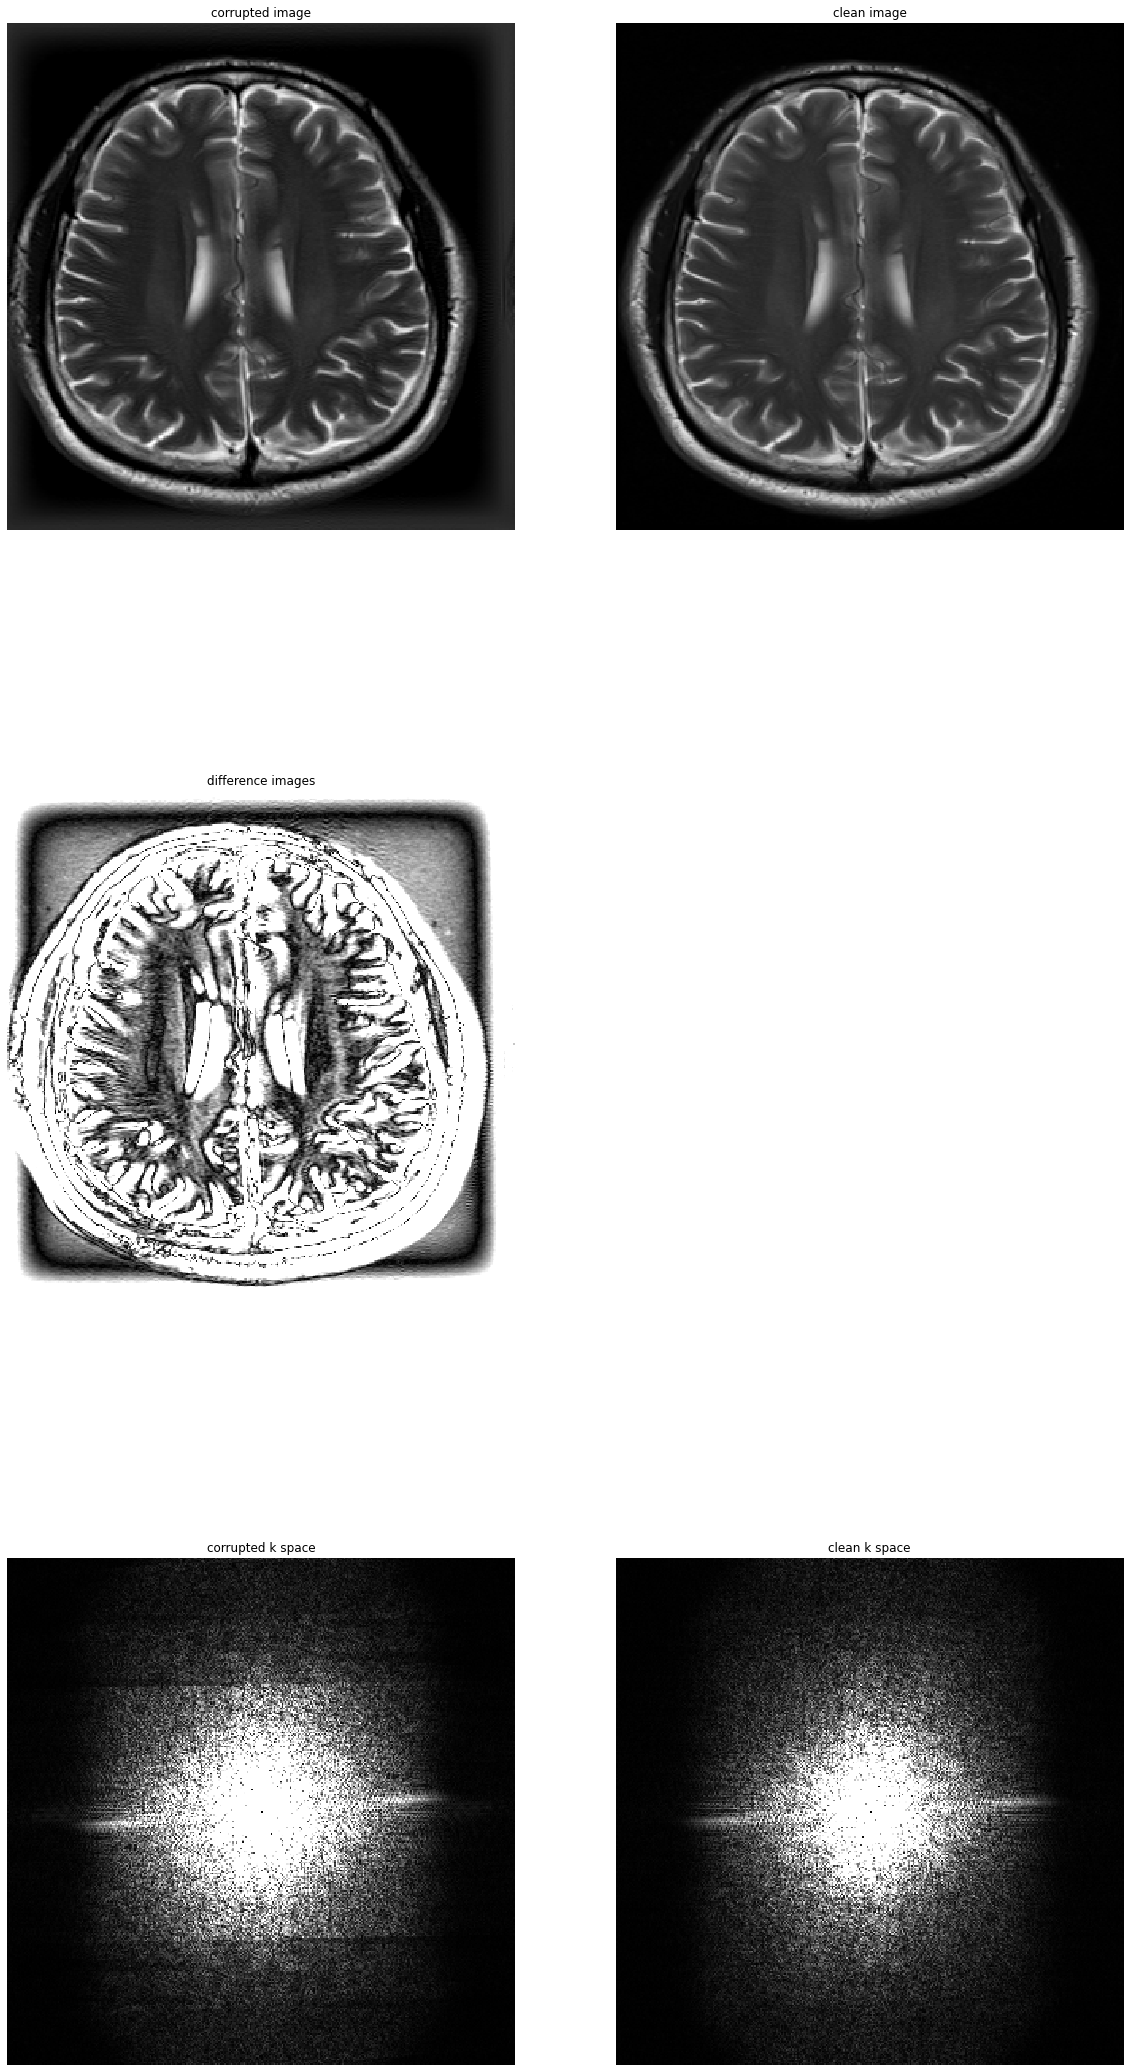

In [6]:
# plotting
hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')